references

https://github.com/yuchenlin/lstm_sentence_classifier/blob/master/LSTM_sentence_classifier_minibatch.py
https://github.com/ThomasGrivaz/pytorch-nlp/blob/master/Sentiment_RNN_Exercise.ipynb

## import libraries

In [1]:
import numpy as np

#to get and read the data
import os
import requests
import zipfile
import gzip
import shutil
import tarfile
from sklearn.model_selection import train_test_split

#to plot the data
%matplotlib inline
import matplotlib.pyplot as plt

#for neural network
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

#print progress
from tqdm.notebook import tqdm

#for evaluation
from sklearn.metrics import classification_report
#for dimension reduction
from sklearn.decomposition import PCA

torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
EMBEDDING_DIM = 200
HIDDEN_DIM = 200
BATCH_SIZE = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## get data

download file

In [3]:
if not os.path.exists('aclImdb_v1.tar.gz'):
    url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
    r = requests.get(url, allow_redirects=True)
    open('aclImdb_v1.tar.gz', 'wb').write(r.content)
    print('zip downloaded')
else:
    print('zip already exists')

zip downloaded


extract file

In [4]:
# extract tar from gz
if not os.path.exists('aclImdb_v1.tar'):
  with gzip.open('aclImdb_v1.tar.gz', 'rb') as f_in:
    with open('aclImdb_v1.tar', 'wb') as f_out:
      shutil.copyfileobj(f_in, f_out)
    print('extracted tar from .gz')
else:
  print('.gz already extracted')

# extract folder from tar
if not os.path.exists('aclImdb'):
  my_tar = tarfile.open('aclImdb_v1.tar')
  my_tar.extractall()
  my_tar.close()
  print('folder extracted from tar')
else:
  print('tar already extracted')

extracted tar from .gz
folder extracted from tar


## read data

In [5]:
def read_data(path, n=12500):
 
  sentis = ['pos', 'neg']
  data = []
  max_len = 500

  for senti in sentis:

    path1 = path + '/' + senti + '/'

    for file in os.listdir(path1)[:n]:
      txt_file = open(path1 + file, "r", encoding="utf8")
      sentences = txt_file.readlines()[0].split()
      # pre-padding with zeroes
      if len(sentences) < max_len:
        sentences = ['0'] * (max_len-len(sentences)) + sentences
      else:
        sentences = sentences[:max_len]  
      sentiment = senti
      data.append([sentences,sentiment])

  return data    

In [6]:
train_data = read_data('aclImdb/train/')
test_data = read_data('aclImdb/test/')
print("first sample :",train_data[0][0])

train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=1)
print("length of train data:",len(train_data))
print("length of val data:",len(val_data))
print("length of test data:",len(test_data))

first sample : ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',

In [7]:
class my_dataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, data):
        'Initialization'
        self.data = data
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)
    
    def __getitem__(self, index):
        target = self.data[index][1]
        data_val = self.data[index][0]
        data_val = " ".join(data_val)
        return data_val,target

        
trainset = my_dataset(train_data)
valset = my_dataset(val_data)
testset = my_dataset(test_data)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=0)
valloader = DataLoader(valset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=0)
testloader = DataLoader(testset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=0)

## preprocessing

In [8]:
def prepare_sequence(seqs, to_ix):
  idxs = []    
  for seq in seqs:
    idxs1 = torch.tensor([to_ix[w] for w in seq], dtype=torch.long)
    idxs.append(idxs1)
  return torch.stack(idxs)

def prepare_targets(seqs, to_ix):
  idxs = []    
  for seq in seqs:
    idxs1 = to_ix[seq]
    if idxs1 == 0:
      idxs1 = torch.tensor([1,0], dtype=torch.float)
    else:
      idxs1 = torch.tensor([0,1], dtype=torch.float)
    idxs.append(idxs1)
  return torch.stack(idxs)    

word_to_ix = {}
for sent, emo in (train_data + val_data + test_data):
  for word in sent:
    if word not in word_to_ix:
      word_to_ix[word] = len(word_to_ix)
            
#print(word_to_ix)
emo_to_ix = {'pos': 0, 'neg': 1}

## define LSTM classifier

In [9]:
class LSTMClassifier(nn.Module):

  def __init__(self, embedding_dim, hidden_dim, vocab_size, label_size, batch_size):
    super(LSTMClassifier, self).__init__()
    self.hidden_dim = hidden_dim
    self.batch_size = batch_size
    self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2)
    self.hidden2label = nn.Linear(hidden_dim, label_size)
    self.hidden = self.init_hidden()

  def init_hidden(self):
    # the first is the hidden h
    # the second is the cell  c
    return (autograd.Variable(torch.zeros(2, self.batch_size, self.hidden_dim)).to(device),
            autograd.Variable(torch.zeros(2, self.batch_size, self.hidden_dim)).to(device))

  def forward(self, sentence):
    embeds = self.word_embeddings(sentence)
    x = embeds.view(len(sentence), self.batch_size , -1)
    lstm_out, self.hidden = self.lstm(x, self.hidden)
    y  = self.hidden2label(lstm_out[-1])
    #log_probs = F.log_softmax(y, dim=1)
    return y

create model

In [10]:
model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(emo_to_ix), batch_size=BATCH_SIZE)
model.to(device)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr = 1e-3)
#optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

## train and evaluate

training

In [11]:
epochs = 5
#set model to train mode
model.train()

for epoch in tqdm(range(epochs)):
  
  train_losses = []
  model.train()
  for data in tqdm(trainloader,0, leave=False):
      
    sentences, emos = data
    sentences = [sentence.split() for sentence in sentences]
    emos = list(emos)
    
    # Step 1. Remember that Pytorch accumulates gradients.
    # We need to clear them out before each instance
    model.zero_grad()

    # Step 2. Get our inputs ready for the network, that is, turn them into
    # Tensors of word indices.
    sentence_in = prepare_sequence(sentences, word_to_ix)
    sentence_in = torch.transpose(sentence_in,0,1)
    sentence_in = sentence_in.to(device)
    #print(sentence_in)
    
    targets = prepare_targets(emos, emo_to_ix)
    model.hidden = model.init_hidden()# detaching it from its history on the last instance.

    # Step 3. Run our forward pass.
    emo_scores = model(sentence_in)
    targets = targets.to(device)

    # Step 4. Compute the loss, gradients, and update the parameters by calling optimizer.step()    
    loss = loss_function(emo_scores, targets)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())


  # print statistics            
  val_losses = []
  model.eval()
  for data in tqdm(valloader,0, leave=False):

    sentences, emos = data
    sentences = [sentence.split() for sentence in sentences]
    emos = list(emos)

    sentence_in = prepare_sequence(sentences, word_to_ix)
    sentence_in = torch.transpose(sentence_in,0,1)
    sentence_in = sentence_in.to(device)
    
    targets = prepare_targets(emos, emo_to_ix)
    model.hidden = model.init_hidden()# detaching it from its history on the last instance.

    emo_scores = model(sentence_in)
    targets = targets.to(device)
    
    loss = loss_function(emo_scores, targets)
    val_losses.append(loss.item())

  print("Epoch: {}/{}...".format(epoch, epochs),
        "Loss: {:.6f}...".format(np.mean(train_losses)),
        "Val Loss: {:.6f}".format(np.mean(val_losses)))

print('Finished Training')

Epoch: 0/5... Loss: 0.632282... Val Loss: 0.595049


Epoch: 1/5... Loss: 0.559752... Val Loss: 0.442173


Epoch: 2/5... Loss: 0.313966... Val Loss: 0.386341


Epoch: 3/5... Loss: 0.134414... Val Loss: 0.438744


Epoch: 4/5... Loss: 0.048962... Val Loss: 0.620999

Finished Training


define evaluation function

In [12]:
def evaluate(data):

  y_true = []
  y_pred = []
  model.eval()

  for data in tqdm(data,0, leave=False):
    with torch.no_grad():
      sentences, emos = data
      sentences = [sentence.split() for sentence in sentences]
      emos = list(emos)

      sentence_in = prepare_sequence(sentences, word_to_ix)
      sentence_in = torch.transpose(sentence_in,0,1)
      sentence_in = sentence_in.to(device)
      
      targets = prepare_targets(emos, emo_to_ix)
      model.hidden = model.init_hidden()# detaching it from its history on the last instance.

      emo_scores = model(sentence_in)
      #print(emo_scores)
      #print(targets)
      for emo, target in zip(emo_scores,targets):
        pred_label = emo.data.max(0)[1].cpu()
        y_true.append(target.max(0)[1])
        y_pred.append(pred_label)
    
    
  print(classification_report(y_true, y_pred, target_names=['pos', 'neg']))

In [13]:
# See what the scores are after training
print('evaluation metrics of test data after training')
evaluate(testloader)

evaluation metrics of test data after training


              precision    recall  f1-score   support

         pos       0.88      0.75      0.81     12500
         neg       0.78      0.90      0.84     12500

    accuracy                           0.82     25000
   macro avg       0.83      0.82      0.82     25000
weighted avg       0.83      0.82      0.82     25000



## Visualize embeddings

get embeddings from model and apply PCA

In [14]:
embeddings = []
for i in model.word_embeddings.parameters():
    embeddings.append(i)

embeddings = embeddings[0].detach().cpu().numpy()
# reduce the number of words
print('total words:',len(embeddings))
embeddings = embeddings[:10000]
    
#print(embeddings)
pca = PCA(n_components=2)
pca = pca.fit_transform(embeddings)
x, y = map(list, zip(*pca))

total words: 421120


visualize embeddings in 2 dimensions

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 132 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 132 missing from current font.
  font.set_text(s, 0, flags=flags)


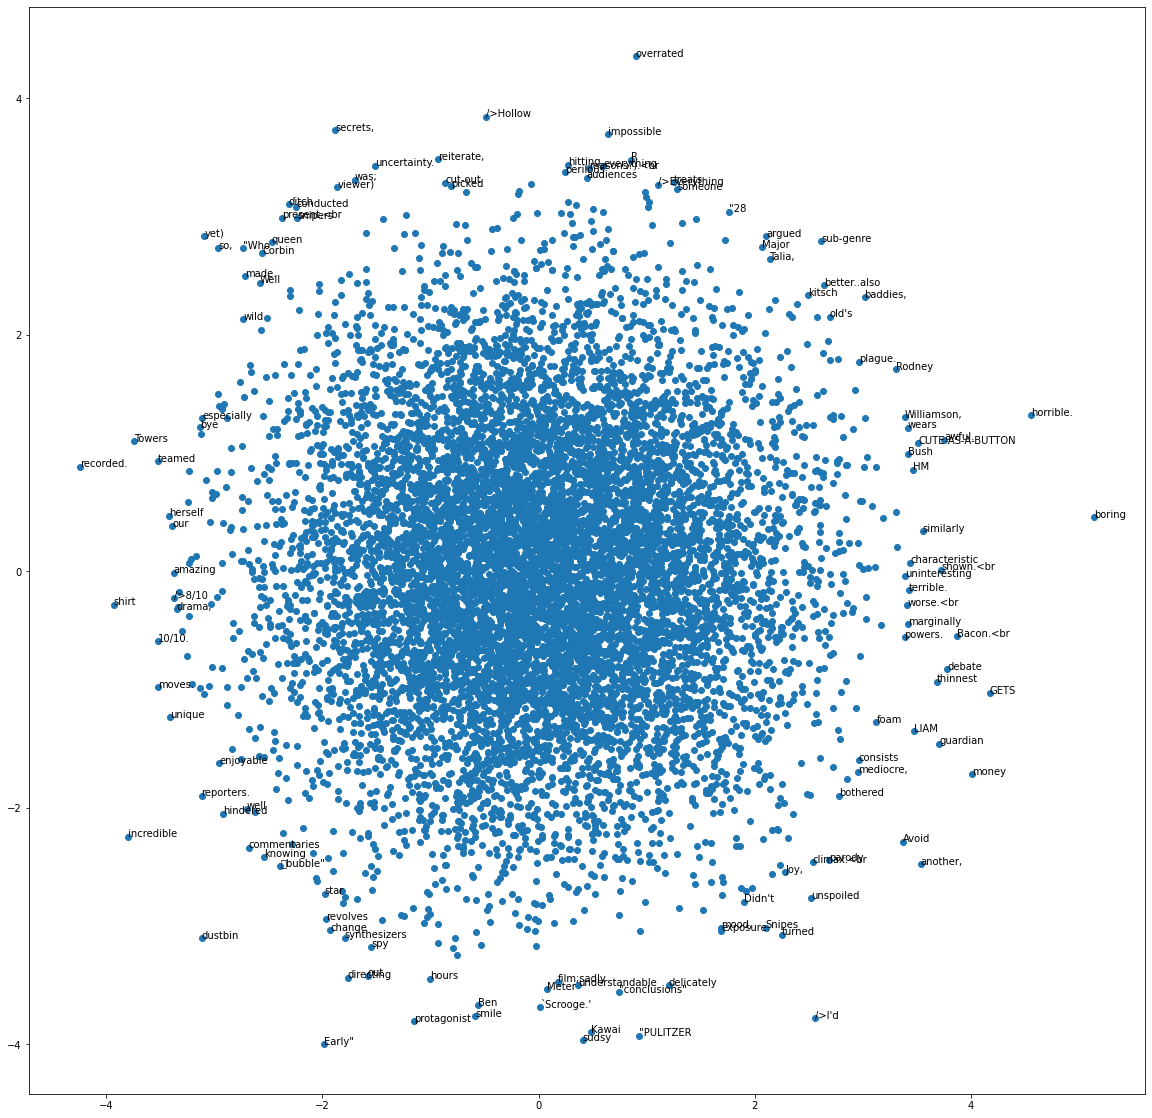

In [15]:
plt.figure(figsize=(20, 20))
plt.scatter(x,y)

'''
The cluster at the center seems to correspond to the stop words or other words 
which does not contribute considerably to the sentiment of the sentence.
The points that lie away from the center are perhaps those words which are
critical and deciding the sentiment of the sentence.
'''

mean = pca.mean(axis=0)

max_d=0
for i,word2d in enumerate(pca):
    dist = np.linalg.norm(word2d-mean)
    if dist > max_d:
        max_d = dist 

wordlist = list(word_to_ix.items())
threshold = 0.65
for i,word2d in enumerate(pca):
    word = wordlist[i][0]
    dist = np.linalg.norm(word2d-mean)
    
    if dist > max_d * threshold:
        #print(dist,print(list(word_to_ix.items())[i][0]))
        plt.annotate(word,(x[i],y[i]))